In [1]:
#import libraries
import re
import random
import itertools
import numpy as np
import pandas as pd 
import seaborn as sn
import matplotlib.pyplot as plt
from string import punctuation
from pandas import DataFrame
from nltk.tokenize import word_tokenize
from nltk.stem.isri import ISRIStemmer
from sklearn import cross_validation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.grid_search import GridSearchCV
%matplotlib inline

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#file uploads as pandas data frame
xls_file = pd.ExcelFile('C:\\Users\\Roaa Abuluka\\Downloads\\redata2.xlsx')
print(xls_file.sheet_names)
data = xls_file.parse('Sheet1')


['Sheet1']


In [3]:
#exploring the data 
print(len(data))
# remove null values 
data = data.dropna() 
# convert column "label" to int
data['Label'] = data['Label'].astype(np.int)
data.head(10)

4712


,text,Label
0,"قلت لى اقفل التلفون وشغلو تانى,لا لا ظرىف\nسود...",0
1,زىن.السودان ممكن نفهم بس القطعة البتحصل دى شنو,-1
2,فكرة دعاىة اضغط نجمة وشىل النغمة دى ما جمىلة...,-1
3,كىف احول رصىد فى زىن ىا جماعة؟ زىن.السودان,0
4,اعلانات زىن، شركة اتصالات ولا ماركة ملابس. ز...,-1
5,سودانى اشتراك شهر نت..زىن اشتراك اسبوع\nارىبا ...,-1
6,قرر ىبارك لرمضان من اسى عشان النت زادوا ما اظن...,-1
7,ى رب نت سودانى ىتنشط,0
8,\nبالمقارنه بزىن اسعارهم كوىسه. .,1
9,\nمعلىش \nخش فى نت سودانى خىاراتهم زابطه.,1


In [4]:
#Stop word removing function, stop words is the useless words in english such as a, an .
def stopwordRemove(text):
    ar_stopword_list = open("C:\\Users\\Roaa Abuluka\\Documents\\stopwords.txt", "r")
    stop_words = ar_stopword_list.read().split('\n')
    needed_words = []
    words = word_tokenize(text)
    for w in words:
        if w not in (stop_words):
            needed_words.append(w)
    filtered_sentence = " ".join(needed_words)
    return filtered_sentence

In [5]:
#upload the stop word file
ar_sw_file = open("C:\\Users\\Roaa Abuluka\\Downloads\\stopwords_dictionary.txt", "r", encoding = 'utf-8')
ar_list = ar_sw_file.read()
print(stopwordRemove("دوما هي الافضل"))

الافضل


In [6]:
#function to reduce the words to the root word
def steaming(text):
    st = ISRIStemmer()
    stemmed_words = []
    words = word_tokenize(text)
    for w in words:
        stemmed_words.append(st.stem(w))
    stemmed_sentence = ' '.join(stemmed_words)
    return stemmed_sentence
print(steaming("دوما هي الافضل"))

دوم هي فضل


In [7]:
#function to normalize the text
def normalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("و", "ؤ", text)
    text = re.sub("ئ", "ء", text)
    return(text)


In [8]:
print(normalizeArabic("دوما هي ألافضل"))

دؤما هي الافضل


In [9]:
#function to remove diacritics from words
def deNoise(text):
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    return text

In [10]:
print(deNoise("دوماٌ هي ألافضل"))

دوما هي ألافضل


In [11]:
#function to remove punctuations
def strip_punctuation(text):
    return ''.join(c for c in text if c not in punctuation)

In [12]:
#function to remove numbers
def remove_numb(text):
    return ''.join(c for c in text if not c.isdigit())

In [13]:
#function to remove the stop-words, steaming 
def prepareDataSet(data):
    sent = []
    for index, r in data.iterrows():
        text = stopwordRemove(r['text'])
        text = steaming(r['text'])
        text = normalizeArabic(r['text'])
        text = deNoise(r['text'])
        text = strip_punctuation(r['text'])
        tetx = remove_numb(r['text'])
        if r['Label'] == -1:
            sent.append([text, 'neg'])
        elif r['Label'] == 1:
            sent.append([text, 'pos'])
        elif r['Label'] == 0:
            sent.append([text, 'obj'])
    df_sent = DataFrame(sent, columns = ['text','Label'])
    return df_sent
prepareDataSet_data = prepareDataSet(data)

In [14]:
np.array(prepareDataSet_data)[100]

array([ '  ىلا الحاجه الاىجابىه انو الناس بتسال عن انترنت سودانى  ىا جماعه نت ام تى ان كعب كعب ما تقربو منو اوعكم  \n\n مقاطعةزىنالس…',
       'neg'], dtype=object)

In [15]:
#function to return term frequency–inverse document frequency witch is 
#a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.
def FeatureExtraction(data):
    vectorizer = TfidfVectorizer(min_df = 10, lowercase = False,max_df = 0.75, ngram_range = (1, 2))
    tfidf_data = vectorizer.fit_transform(data)
    return tfidf_data

In [16]:
def learing(clf, X, Y):
    X_train, X_test, Y_train, Y_test = \
    cross_validation.train_test_split(X,Y, test_size = 0.4, random_state = 43)
     
    classifer = clf()
    classifer.fit(X_train, Y_train)
    predict = cross_validation.cross_val_predict(classifer, X_test, Y_test, cv=10)
    score = cross_validation.cross_val_score(classifer, X_test, Y_test, cv=10)
    print(score)
    

In [17]:
def main(clf):
    xls_file = pd.ExcelFile('C:\\Users\\Roaa Abuluka\\Downloads\\redata2.xlsx')
    data = xls_file.parse('Sheet1')
    prepareDataSet_data = prepareDataSet(data)
    data, target = prepareDataSet_data['text'], prepareDataSet_data['Label']
    tfidf_data = FeatureExtraction(data)
    learing(clf, tfidf_data, target)
    
    

In [18]:
clfs = [MultinomialNB, SVC, LogisticRegression]

In [19]:
for clf in clfs:
    main(clf)

[ 0.71052632  0.70526316  0.70526316  0.70899471  0.7287234   0.71276596
  0.71276596  0.7287234   0.71657754  0.72192513]
[ 0.7         0.7         0.7         0.7037037   0.70744681  0.70744681
  0.70744681  0.70744681  0.70588235  0.70588235]
[ 0.73684211  0.72105263  0.71052632  0.71428571  0.7287234   0.70744681
  0.7287234   0.71276596  0.71122995  0.72727273]


In [20]:
xls_file = pd.ExcelFile('C:\\Users\\Roaa Abuluka\\Downloads\\redata2.xlsx')
data = xls_file.parse('Sheet1')
prepareDataSet_data = prepareDataSet(data)
data, target = prepareDataSet_data['text'], prepareDataSet_data['Label']
tfidf_data = FeatureExtraction(data)
learing(clf, tfidf_data, target)    

[ 0.73684211  0.72105263  0.71052632  0.71428571  0.7287234   0.70744681
  0.7287234   0.71276596  0.71122995  0.72727273]


# KNN

In [21]:
#Grid search the hyper-parameter for KNN
knn_clf = KNeighborsClassifier()
param_knn = {
    'n_neighbors': [1, 2]
}
knn_grid = GridSearchCV(knn_clf, param_knn, cv = 3, scoring = 'f1_micro', n_jobs=2)

In [22]:
%time
score = knn_grid.fit(tfidf_data, target)
score.best_params_

Wall time: 0 ns


{'n_neighbors': 2}

In [23]:
# accuracy score for KNN
score.best_score_
knn_clf = score.best_estimator_
pred_y = knn_clf.predict(tfidf_data)
accuracy_score(target, pred_y)

0.9006580343876035

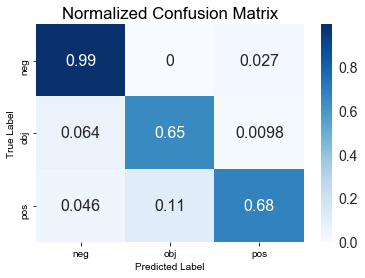

In [24]:
# plot confusion matrix for KNN
KNNconfusion = confusion_matrix(target, pred_y)
knn_cm = KNNconfusion / KNNconfusion.astype(np.float).sum(axis=1)
ax = plt.axes()
df_cm = pd.DataFrame(knn_cm ,columns= ["neg", "obj", "pos"], index = ["neg", "obj", "pos"])
sn.set(font_scale = 1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap = "Blues" , ax = ax, xticklabels='auto')
ax.set_title("Normalized Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Naive Bayes

In [25]:
# Grid search Naive Bayes hyper-parameter
mltiNB_clf = MultinomialNB()
param_MltiNB = {
    'alpha': [0.0, 0.2, 0.5, 0.6, 0.8, 1.0]
    
}
MultiNB_grid = GridSearchCV(mltiNB_clf, param_MltiNB, cv = 3, scoring = 'f1_micro', n_jobs=3)

In [26]:
%time
MultiNB_score = MultiNB_grid.fit(tfidf_data, target)

Wall time: 0 ns


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [27]:
MultiNB_score.best_score_


0.7302059010825727

In [28]:
MultiNB_score.best_params_

{'alpha': 0.0}

In [29]:
# accuracy score for NB
bestMltiNB_clf = MultiNB_score.best_estimator_
predNB_y = bestMltiNB_clf.predict(tfidf_data)
accuracy_score(target,predNB_y)

0.7847590745064742

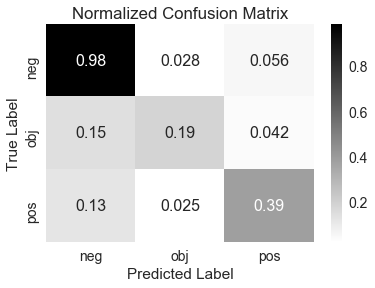

In [30]:
# plot confusion matrix for Naive Bayes 
Naive_cm = confusion_matrix(target, predNB_y)
NB_cm = Naive_cm / Naive_cm.astype(np.float).sum(axis=1)
ax = plt.axes()
df_cm = pd.DataFrame(NB_cm ,columns= ["neg", "obj", "pos"], index = ["neg", "obj", "pos"])
sn.set(font_scale = 1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap = "gray_r" , ax = ax, xticklabels='auto')
ax.set_title("Normalized Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# SVM

In [31]:
svm_clf = SVC()

In [33]:
# Grid search SVM hyper-parameters
param_svm = {
    'kernel':('linear', 'rbf'),
    'C':[5, 10, 15]
}
svm_grid = GridSearchCV(svm_clf, param_svm, cv=3, scoring = 'f1_micro', n_jobs=4)

In [34]:
%%time
svm_score = svm_grid.fit(tfidf_data, target)

Wall time: 19.8 s


In [35]:
svm_score.best_score_

0.7161961367013373

In [36]:
svm_score.best_params_

{'C': 5, 'kernel': 'linear'}

In [37]:
# accuracy score for SVM
bestsvm_clf = svm_score.best_estimator_
predSVM_y = bestsvm_clf.predict(tfidf_data)
accuracy_score(target, predSVM_y)

0.84886436000849075

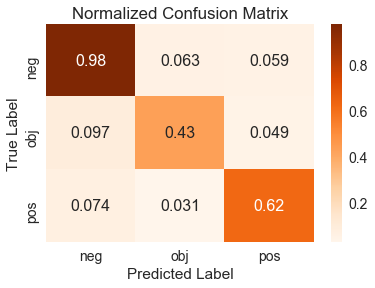

In [38]:
# plot confusion matrix for support vector machine 
SVM_confustion = confusion_matrix(target, predSVM_y)
SVM_cm = SVM_confustion / SVM_confustion.astype(np.float).sum(axis=1)
ax = plt.axes()
df_cm = pd.DataFrame(SVM_cm ,columns= ["neg", "obj", "pos"], index = ["neg", "obj", "pos"])
sn.set(font_scale = 1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap = "Oranges" , ax = ax, xticklabels='auto')
ax.set_title("Normalized Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Logistic Regression

In [39]:
log_clf = LogisticRegression()

In [40]:
# Grid search logistic Regression hyper-parameters
param_logistic = {
    #'penalty':('12'),
    'C':[0.2, 0.5, 0.6, 0.8, 1.0]
}
log_grid = GridSearchCV(log_clf, param_logistic, cv=3, scoring = 'f1_micro')

In [41]:
%%time
log_score = log_grid.fit(tfidf_data, target)

Wall time: 881 ms


In [42]:
log_score.best_score_

0.7316917851836128

In [43]:
log_score.best_params_

{'C': 1.0}

In [44]:
# accuracy score for Logistic Regression
best_clf = log_score.best_estimator_
predLOG_y = best_clf.predict(tfidf_data)
accuracy_score(target, predLOG_y)

0.77775419231585652

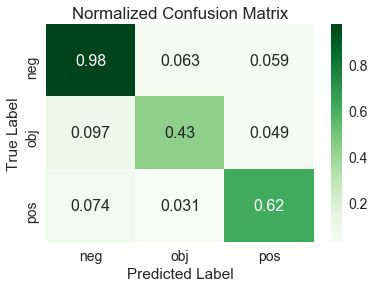

In [45]:
# plot Logistic Regression confusion matrix  
LR_confustion = confusion_matrix(target, predLOG_y)
LR_cm = LR_confustion / LR_confustion.astype(np.float).sum(axis=1)
ax = plt.axes()
df_cm = pd.DataFrame(SVM_cm ,columns= ["neg", "obj", "pos"], index = ["neg", "obj", "pos"])
sn.set(font_scale = 1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap = "Greens" , ax = ax, xticklabels='auto')
ax.set_title("Normalized Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')